LAB2 by Lin Sinan

In [2]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm, tqdm_notebook
from operator import is_not
from functools import partial
from keras import backend as k
from keras.models import Sequential, Model
from keras.layers import Dense, Convolution2D, MaxPool2D, Flatten
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
print(cv2.__version__)

3.4.2


In [3]:
class imageQuerier:
    """ load the sift_detector as a static member which helps to save time """
    __sift = cv2.xfeatures2d.SIFT_create()

    def __init__(self, images, labels, isTask3 = False):
        """
            @index: images' paths
            @labels: images' labels
            @isTask3: it is for task3(using CNN instead of VBoW) or not.
        """
        print("LOADING IMAGES!")
        # if we just want to build a BoW model, we just need the sift descriptors of them, 
        # and it helps to improve the speed of querying
        if isTask3:
            self.images = np.asarray([cv2.resize(cv2.imread(images[i],1), (112, 112), cv2.INTER_LINEAR) for i in tqdm_notebook(range(len(images)))])
            self.images = preprocess_input(self.images) # image normalization and change the shape from (224, 224, 3, 30000) to (30000, 224, 224, 3)
        else:
            self.images = np.asarray([imageQuerier.__sift.detectAndCompute(cv2.imread(images[i],0), None)[1] for i in tqdm_notebook(range(len(images)))])
            
            
        self.labels = labels
        self.paths = images
        self.query_image = None 
        self.size = len(images)
        self.isTask3 = isTask3
        self.BOW_init = False

    def match(self, index, factor = 0.75):
        """
            match two pictures by their sift descriptors(the query image and image at index i).
            
            @index : if it is used for task 1, it is a list of two pictures' indeces.
                    Otherwise, it is a intergal (the index of the image will be compared)
            @factor : the threshold for chosing 'similar' descriptors.
        """
        assert(self.isTask3 == False)
        des1 = self.query_descripor
        des2 = self.images[index]

        if type(des2) == type(None) or len(des2) <= 2:
            return 0

        # FLANN parameters
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 2)
        search_params = dict(checks=50) # or pass empty dictionary

        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des1,des2,k=2)
        matchesMask = [[0,0] for i in range(len(matches))]

        cnt = 0
        # ratio test as per Lowe's paper
        for i,(m,n) in enumerate(matches):
            if m.distance < factor*n.distance:
                matchesMask[i]=[1,0]
                cnt += 1
        return cnt

    def query(self, image, factor = 0.75):
        """
        user interface for image querying(Near Duplicate). 
        
        @image : the image will be queried(in our case, it is the image gets 
                 geographical transformation)
        @factor : a hyperparameter for chosing 'similar' descriptors.
      """
        print("Query(SIFT Matcher Retrieval) Start!")
        self.query_image = image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, self.query_descripor = self.__sift.detectAndCompute(gray, None)
        
        if self.query_descripor is None or len(self.query_descripor) <= 2:
            print("Entered Picture doesnt have enough key points")
            raise AssertionError

        """ 
          match every image in the image set, and compute their similarity score
          based on the numbers of 'similar' descriptors
        """
        scores = {i:0 for i in range(self.size)}
        for i in tqdm_notebook(range(self.size)):
            score = self.match(index = i, factor = factor)
            scores[i] = score

        # This output is just for ploting results.
        top_similar_pic_index = sorted(scores,  key=scores.get, reverse = True)
        return {idx:scores[idx]/max(scores.values()) for idx in top_similar_pic_index[:12]}
    

    def BOWquery(self, image, N= 50):
        """
            it is a user interface for using tf-idf weighted BoW querying model. 
        
            @image : the image will be queried
            @factor : a theshold for chosing 'similar' descriptors.
        """
        
        self.query_image = image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, query_des = self.__sift.detectAndCompute(gray, None)
        
        if not self.BOW_init:
            print("Building Vocaburary!")
            self.__build_vocaburary(N)
            self.BOW_init = True
            
        # convert to hist representation
        des_to_hist = self.kmeans.predict(query_des)
        hist_query_img = np.zeros(N)
        for i in des_to_hist:
            hist_query_img[i] += 1

        # Compute the similarity, and return top 12 similar images

        """ 
            this lambda function `cos_sim` to compute the consine similarity of two vectors for using 
            numpy.apply_along_axis(faster than `for` loop). add a small number to make sure denominator 
            is not equal to 0
        """
        cos_sim = lambda a,b : np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b) + 0.001) 

        similarity = np.apply_along_axis(partial(cos_sim, hist_query_img), 0, self.weight_voc)
        similarity = np.nan_to_num(similarity)
        rank_12_index = similarity.argsort()[-12:][::-1]
        return {i : similarity[i] for i in rank_12_index}

    def __build_vocaburary(self, N):
        """
            Build tf-idf weighted vocaburary/codebook using K-means algorithm

            @N : the number of clusters in kmeans
        """

        # drop the images which dont have descriptors(None filter)
        list_des = list(filter(None.__ne__, self.images))
        descriptors_list = np.vstack(list_des)
        self.N = N
        self.kmeans = MiniBatchKMeans(n_clusters=N, random_state=0, batch_size=64)
        self.kmeans.fit(descriptors_list)
        cluster_of_each_descriptor = self.kmeans.predict(descriptors_list)

        """
            images can have different numbers of keypoints, I use a counter(cnt) here 
            to make sure the descriptors can find its recorresponding image
        """
        cnt = 0 
        vocaburary = np.zeros((N, self.size))
        for i in range(self.size):
            # some images doesnt have descriptors(for task2 we load descriptors instead of image),
            # so self.images here is actually images' descriptors
            if self.images[i] is None:
                continue
            n = self.images[i].shape[0]
            centered_des = cluster_of_each_descriptor[cnt:(cnt+n)]
            for j in centered_des:
                vocaburary[j, i] += 1
            cnt += n

        # TF-IDF weight
        tf = vocaburary/(np.sum(vocaburary, 0)+0.1)
        idf = np.log(self.size / np.sum(vocaburary, 1))
        tf_idf = np.multiply(tf, idf.reshape(-1,1))
        self.weight_voc = np.multiply(vocaburary, tf_idf) # tf-idf weighted
    
    # def __descriptor_to_hist(self, descriptor_vector):
    #     return np.argmin(np.linalg.norm(self.center - descriptor_vector, axis=1))

    # def __tfidf_weight(self, hist_query_img, n):
    #     tf = hist_query_img / (1+hist_query_img)
    #     df = (np.sum(self.vocaburary, 1) + 0.5)/ (np.sum(self.vocaburary)+0.5) 
    #     idf = np.log(1/df)
    #     return tf * idf

    def build_classifier(self, fit_params):
        if self.isTask3:
            # Task 3:Using CNN to retrieve images
            self.model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

            # Freeze the required layers
            for layer in self.model.layers[:-4]:
                layer.trainable = False

            """
              Add two fully connected layers and a softmax layer 
              function `.add` doesn't work in my version. solution I use is the link below
              https://github.com/keras-team/keras/issues/4040
            """
            last = self.model.output
            last = Flatten()(last)
            # add two dense layers and softmax layers
            last = Dense(2048, activation='relu')(last)
            last = Dense(1024, activation='relu')(last)
            preds = Dense(43, activation='softmax')(last)
            self.model = Model(self.model.input, preds)
        else:
            # for last step of task2 : Train a neural network to classify several categories
            self.model = Sequential([Dense(258, input_dim=self.N, activation="relu"),
                                Dense(128, activation="relu"),
                                Dense(128, activation="relu"),
                                Dense(43, activation="softmax")])
        self.__train(fit_params)
        
    def __train(self, fit_params):
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                           metrics=['accuracy'])
        
        """
            Keras's shuffle starts after spliting dataset, and it brings problems(Val data set might be just pictures from label 42).
            https://stackoverflow.com/questions/52439468/keras-how-to-take-random-samples-for-validation-set
        """
        idx = np.arange(0, self.size)
        np.random.shuffle(idx)
        
        if self.isTask3:
            history = self.model.fit(self.images[idx], self.labels[idx], **fit_params)
        else:
            history = self.model.fit(self.weight_voc.T[idx], self.labels[idx], **fit_params)

        # Plot training result
        self.history = history
        # Plot training result
        plt.figure(figsize = (20,16))
        grid = plt.GridSpec(1, 2)
        plt.subplot(grid[0,0])
        plt.plot(iq.history.history['acc'])
        plt.plot(iq.history.history['val_acc'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

        plt.subplot(grid[0,1])
        plt.plot(iq.history.history['loss'])
        plt.plot(iq.history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    def plot_query_result(self, top_similar_pic, size = (20, 15)):
        """
        It is a function helps to plot the querying result. 
        
        @top_similar_pic : it is a dictionary. Its key is image indexes, and
                           its value is the similarity score of that image.
        @size : the size of image will be displayed 
        """
        plt.figure(figsize=size)
        grid = plt.GridSpec(2, 4)
        plt.subplot(grid[:2, :2])
        plt.imshow(cv2.cvtColor(self.query_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Entered Picture")

        keys = list(top_similar_pic.keys())
        for i, idx in enumerate(keys[:4]):
            plt.subplot(grid[i//2, 2+i%2])
            if self.isTask3:
                img = cv2.cvtColor(self.images[idx], cv2.COLOR_BGR2RGB)
            else:
                img = cv2.cvtColor(cv2.imread(self.paths[idx],1 ), cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title("Top {}, Score {:.2f}".format(i+1, top_similar_pic[idx]))
            plt.axis("off")
        plt.show()

        plt.figure(figsize=size)
        grid = plt.GridSpec(2, 4)
        for i, idx in enumerate(keys[4:]):
            plt.subplot(grid[i//4, i%4])
            if self.isTask3:
                img = cv2.cvtColor(self.images[idx], cv2.COLOR_BGR2RGB)
            else:
                img = cv2.cvtColor(cv2.imread(self.paths[idx],1 ), cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title("Top {}, Score {:.2f}".format(i+5, top_similar_pic[idx]))
            plt.axis("off")
        plt.show()

    @staticmethod
    def display(img, size = (20, 15)):
        """
            A function used to plot an image. If `img` is a string, it supposes to be the path.
            Otherwise, it's a BGR/gray image

            @image : the image will be displayed 
            @size : the size of image will be displayed 
        """
        if isinstance(img, str) :
            img = cv2.imread(img, 1)
        plt.figure(figsize=size)
        plt.axis("off")
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
        else:
            plt.imshow(img,cmap='gray')
        plt.show()

    @staticmethod
    def plot(path, size = (20, 15)):
        """For debugging"""
        img = cv2.imread(path, 1)
        imageQuerier.display(img, size)

    @classmethod
    def get_sift(cls):
        """
          Get sift detector. It is just for debugging
        """
        return cls.__sift

def random_index(_min, _max):
    """
      Get a random number between _min and _max
    """
    np.random.seed(250)
    return np.random.randint(_min, _max)

def load_data(data_directory):
    """
      Loading the traffic sign data from local path
      @data_directory: the path of traffic sign data
    """
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    _dict = {int(label):[] for label in directories}
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) ]
        label = int(d)
        for filename in file_names:
            images.append(filename)
            labels.append(label)
            _dict[label].append(filename)
    return images, labels, _dict

def generate_random_image(label_dict):
    # get a random picture whitin STOP label
    label_idx = 14 # index of STOP
    image_idx = random_index(0, len(label_dict[label_idx]))
    return cv2.imread(label_dict[label_idx][image_idx], 1)

# load images and labels

In [4]:
ROOT_PATH = "data"
train_data_directory = os.path.join(ROOT_PATH, "TrafficSigns/Train")
images_train, labels_train, label_dict = load_data(train_data_directory)

 # Task1: near duplicate query

In [5]:
image = generate_random_image(label_dict)
iq = imageQuerier(images_train, np.array(labels_train), isTask3=False)

## get top 12 most similar images in the whole dataset
top_similar = iq.query(image)

LOADING IMAGES!


A Jupyter Widget


Query(SIFT Matcher Retrieval) Start!


A Jupyter Widget

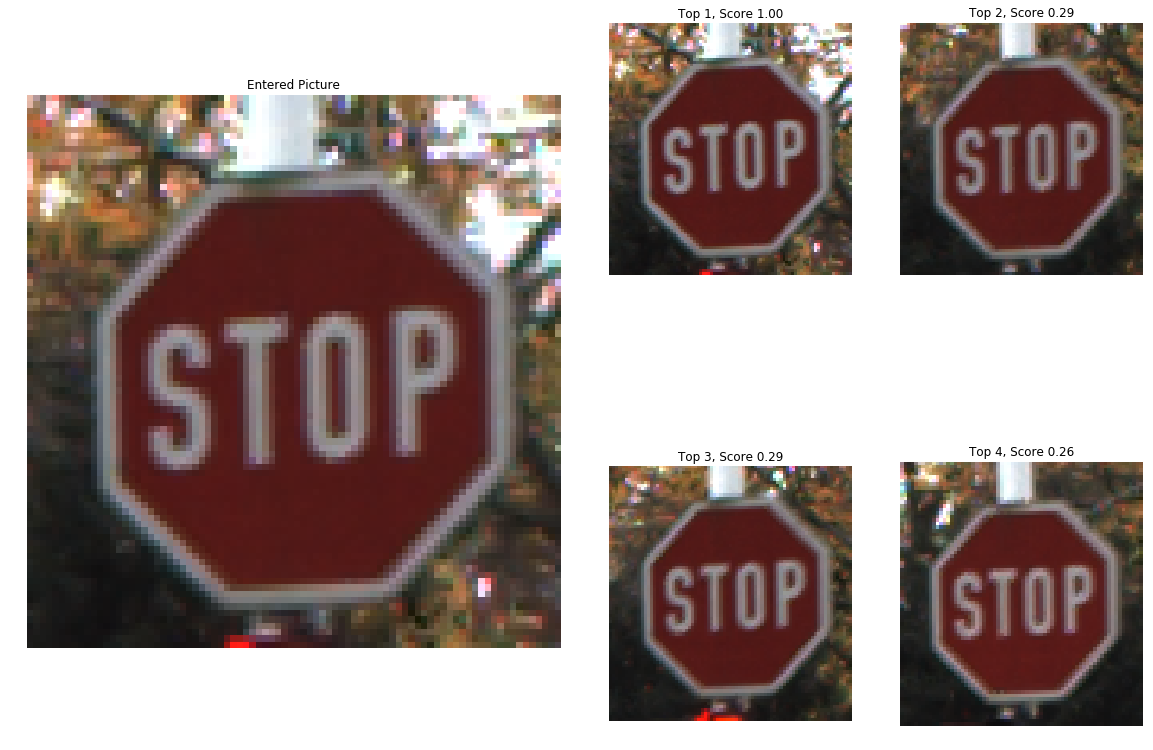

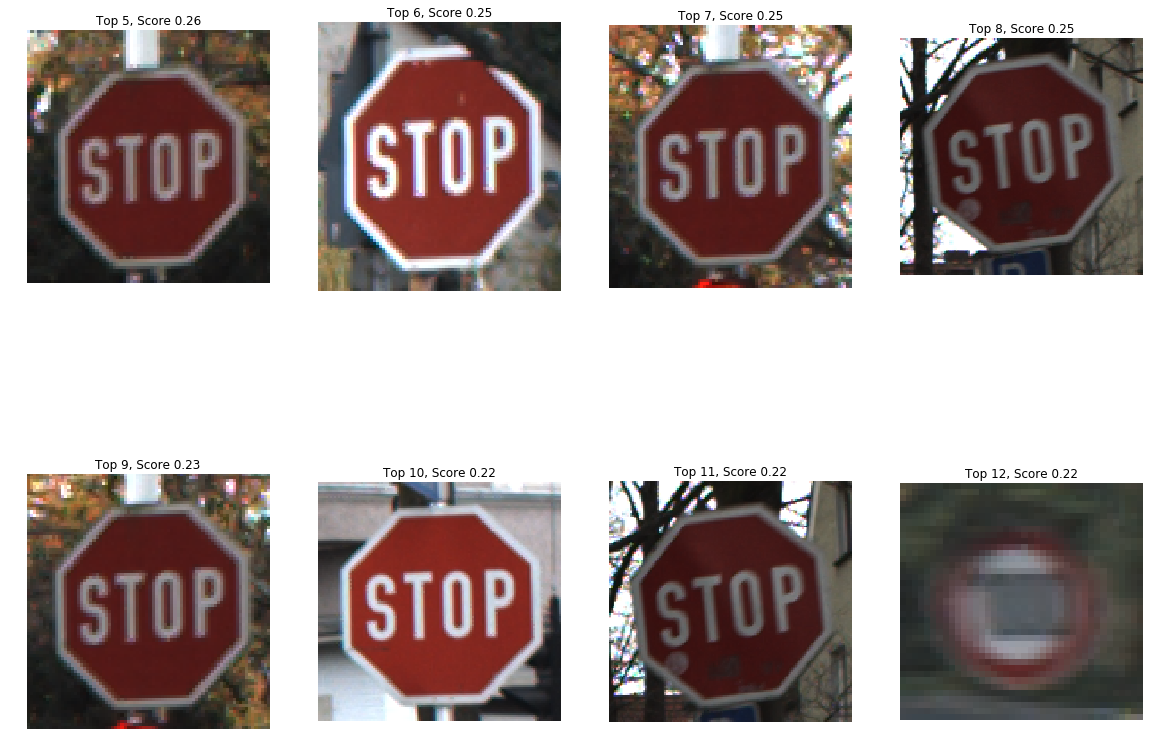

In [6]:
iq.plot_query_result(top_similar)

# Task2: Using Bag-of-Word model to represent Images

## I also try to use cosine similarity of weighted BoW to query an image. It also works better 

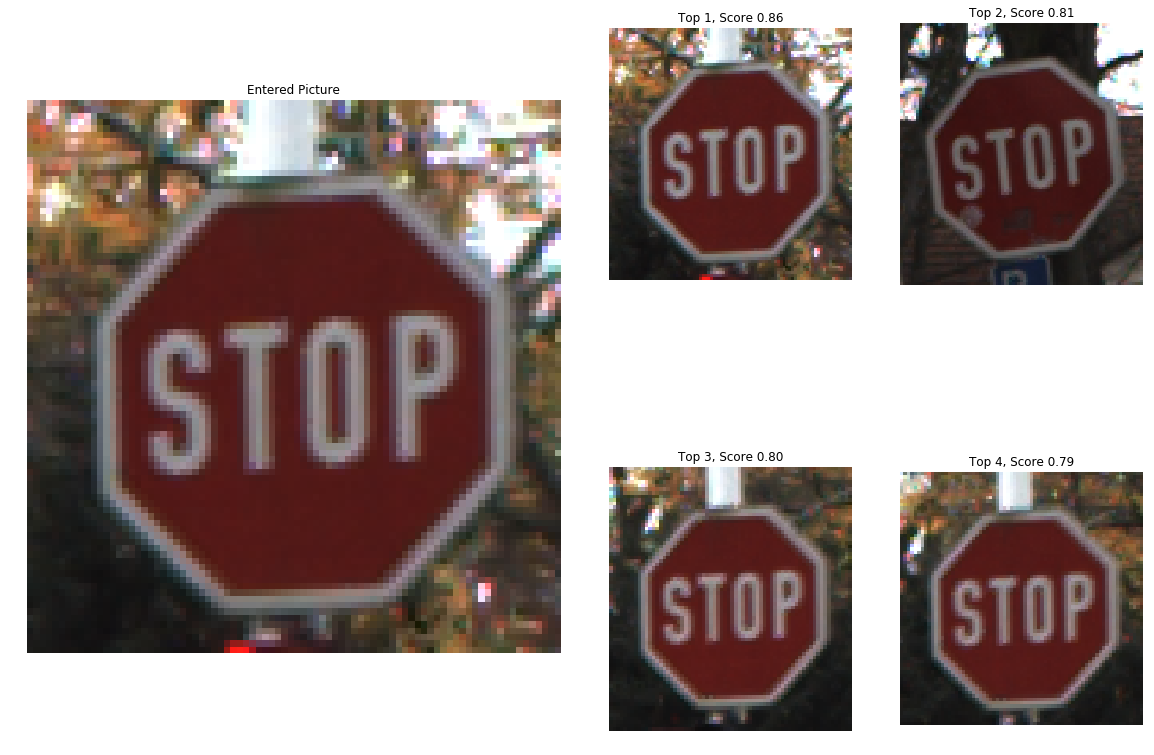

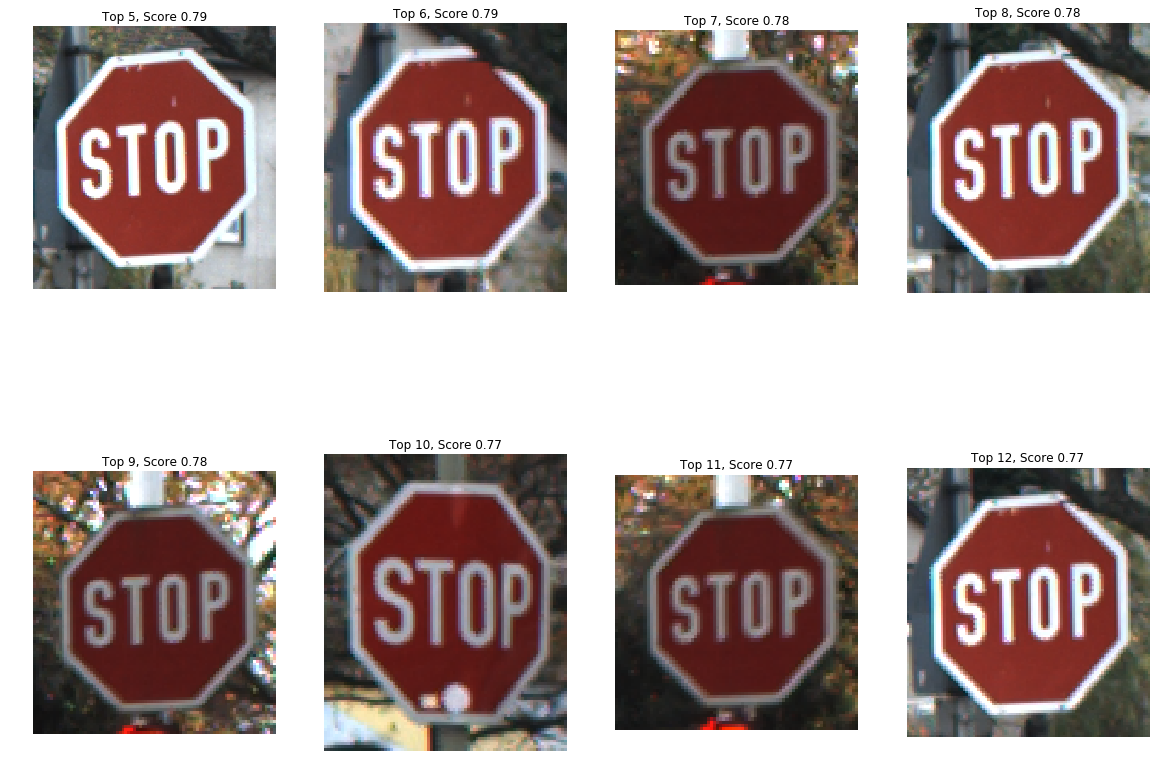

In [8]:
N = 50
rank_12_sim = iq.BOWquery(image, N)
iq.plot_query_result(rank_12_sim) # BoW query

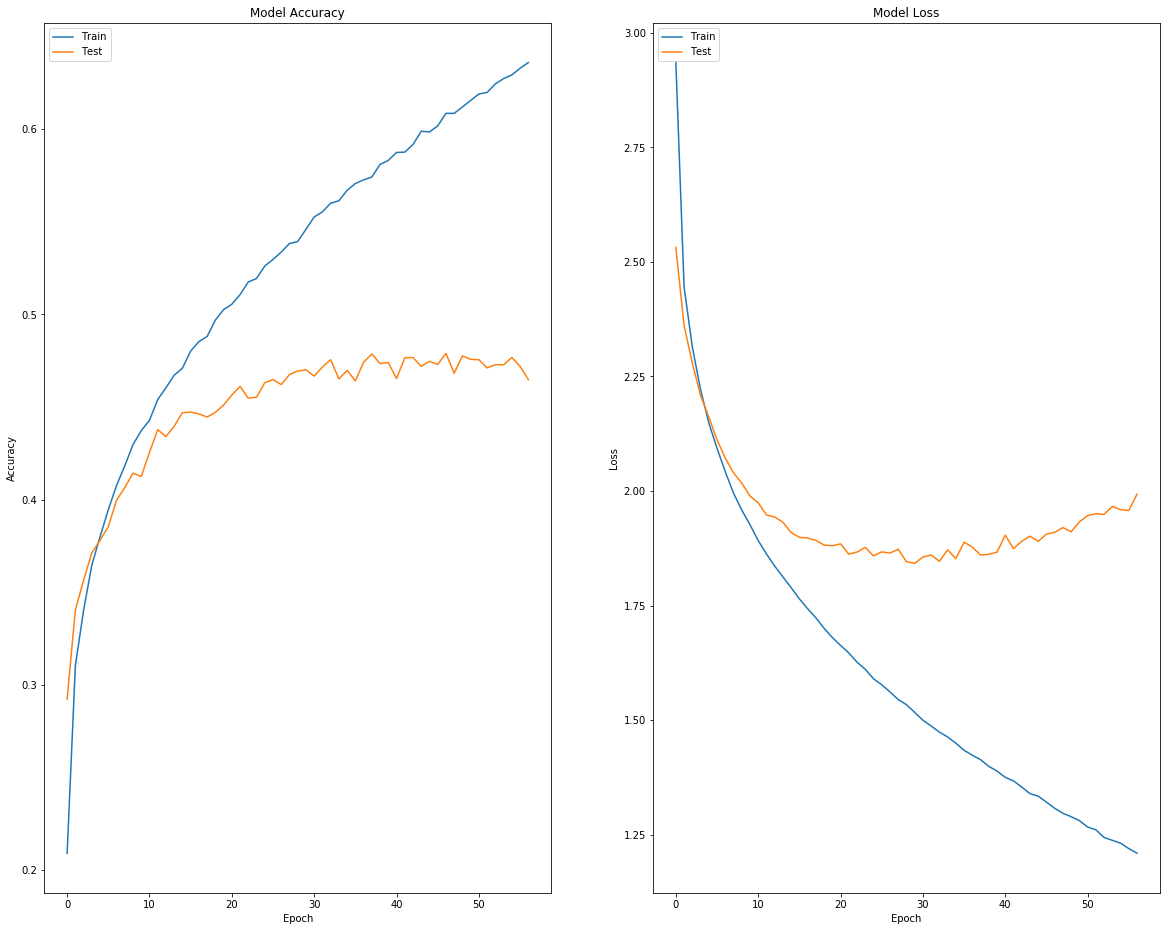

In [11]:
# Train a neural network for weighted BoW
fit_params = {
    "batch_size": 128,
    "epochs": 200,
    "shuffle":True,
    "verbose":0,
    "validation_split": 0.15,
    "callbacks":[EarlyStopping(monitor='val_acc',patience=10)]
}

iq.build_classifier(fit_params)

# Task3: Using Convolutional Neural Network to represent Images

In [12]:
iq = imageQuerier(images_train, np.array(labels_train), isTask3=True)

LOADING IMAGES!


A Jupyter Widget

In [13]:
fit_params = {
        "batch_size": 64,
        "epochs": 100,
        "shuffle":True,
        "verbose":0
        "validation_split": 0.15,
        "callbacks":[EarlyStopping(monitor='val_acc',patience=10)]
}
iq.build_classifier(fit_params)

SyntaxError: invalid syntax (<ipython-input-13-213e3ed938a0>, line 6)